# CIMP6 

## Data Retreval here will happen within this notebook using [OPeNDAP](https://en.wikipedia.org/wiki/OPeNDAP)


### Overveiw 

In this notebook we will:

* Get some data straight into the notebook using OPeNDAP
* use xarray to:
    * explore the data
    * explore metadata
    * visualise the data 


### Outcomes 

* Use [xarray](https://xarray.pydata.org/en/stable/index.html) to explore and visualise climate data 

#### Prerequisites 
To successfully navigate this notebook, you should be accustom with:
* Basics of python programming:
    * loading modules 
    * variable assignment 
    * basic plotting packages (`Matplotlib.pyplot`)
* Basic knowledge of arrays and indexing
* Have a basic understanding of weather and climate, for example:
    * Latitude is North-South
    * Longitude is East-West
* some experience with pandas would be great, have a look at "Exploring_tabular_data_with_pandas.ipynb"


### Background 

* xarray is an open-source project python package for working with multi-dimension arrays- climate data!
* xarray is inspired by and borrows heavily from pandas, if you're familiar with pandas xarray will come quite naturally
* Coupled Model Intercomparison Project (CMIP) is a ocean-atmosphere coupled climate model
* CMIP6 is the latest iteration of this project 
* more information on xarray and CMIP here: 
    * [xarray](https://xarray.pydata.org/en/stable/index.html) 
    * [CMIP](https://www.wcrp-climate.org/wgcm-cmip)
    


In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import xarray as xr 
import numpy as np 
import requests
xr.set_options(display_style='html')


We are retriving data from the [Earth System Grid Federation (ESGF)](https://esgf.llnl.gov/) using the [ESGF search API](https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API). The code here comes from this [notebook](https://nbviewer.org/github/pangeo-data/pangeo-cmip6-examples/blob/master/search_and_load_with_esgf_opendap.ipynb) linked from this [CMIP6 in the Cloud Five Ways](https://medium.com/pangeo/cmip6-in-the-cloud-five-ways-96b177abe396) article. Here we are using method 1. 

In [2]:
def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = [] 
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)

This function returns URLs of the matching veriables. The catalog can be found [here](https://esgf-node.llnl.gov/search/cmip6/) to see what is available. 

In [3]:
result = esgf_search(activity_id='CMIP', table_id='Amon', variable_id='tas', experiment_id='historical',
                  institution_id="NCAR", source_id="CESM2", member_id="r10i1p1f1")
result

https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&variable_id=tas&experiment_id=historical&institution_id=NCAR&source_id=CESM2&member_id=r10i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&variable_id=tas&experiment_id=historical&institution_id=NCAR&source_id=CESM2&member_id=r10i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10


['http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/historical/r10i1p1f1/Amon/tas/gn/v20190313/tas_Amon_CESM2_historical_r10i1p1f1_gn_185001-189912.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/historical/r10i1p1f1/Amon/tas/gn/v20190313/tas_Amon_CESM2_historical_r10i1p1f1_gn_190001-194912.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/historical/r10i1p1f1/Amon/tas/gn/v20190313/tas_Amon_CESM2_historical_r10i1p1f1_gn_195001-199912.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/historical/r10i1p1f1/Amon/tas/gn/v20190313/tas_Amon_CESM2_historical_r10i1p1f1_gn_200001-201412.nc',
 'http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/CMIP/NCAR/CESM2/historical/r10i1p1f1/Amon/tas/gn/v20190313/tas_Amon_CESM2_historical_r10i1p1f1_gn_185001-189912.nc',
 'http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/CMIP/NCAR/CESM2/historical/r10i1p1f1/Amon/tas/gn/v20190313/tas_Amon_CESM2

* here we are selecting the last 4 files to open into a cube 
* we are going to do this with `open_mfdataset` which is to open multiple files as a single dataset 
* we are also going to set `combine='by_coords'` which combines each file by their coordinates
* this returns a dataset containing 
    * dimensions
    * coordinates
    * data variables
    * attributes 

In [4]:
# there are mulitple sources of the same data--need to pick one
files_to_open = result[-4:]

ds = xr.open_mfdataset(files_to_open, combine='by_coords')
ds

/home/h06/ncreaser/.conda/envs/climate_ml_tutorial/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, time: 1980, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    time_bnds  (time, nbnd) object dask.array<chunksize=(600, 2), meta=np.ndarray>
    lat_bnds   (time, lat, nbnd) float64 dask.array<chunksize=(600, 192, 2), meta=np.ndarray>
    lon_bnds   (time, lon, nbnd) float64 dask.array<chunksize=(600, 288, 2), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
Attributes: (12/46)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            674885.0
    branch_time_in_parent:           306600.0
    case_id:                         24
    ...                              ...
    table_id:                        Amon
    tracking_id:                     hdl:21.14100/e47b79db-3925-45a7-9c0a-679...
    variable_id:                     tas
    variant_info:                    CMIP6 20th century experiments (1850-201...
    variant_label:                   r10i1p1f1
    DODS_EXTRA.Unlimited_Dimension:  time

Now we have loaded our URl's into a dataset, we can see under data variables one of the variables is out field tas (near-surface air temperature) 

* To access this as a dataarray, we can do `ds.tas` which returns a dataarray 

In [5]:
ds.tas

<xarray.DataArray 'tas' (time: 1980, lat: 192, lon: 288)>
dask.array<concatenate, shape=(1980, 192, 288), dtype=float32, chunksize=(600, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      mon
    id:             tas
    long_name:      Near-Surface Air Temperature
    mipTable:       Amon
    out_name:       tas
    prov:           Amon ((isd.003))
    realm:          atmos
    standard_name:  air_temperature
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    units:          K
    variable_id:    tas
    _ChunkSizes:    [  1 192 288]

From our dataarray we can select different slices and dimensions 

* To select the timestamp from 1950-01 we can use `.sel(time='1950-01')`


In [6]:
ds.tas.sel(time='1950-01')

<xarray.DataArray 'tas' (time: 1, lat: 192, lon: 288)>
dask.array<getitem, shape=(1, 192, 288), dtype=float32, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1950-01-15 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      mon
    id:             tas
    long_name:      Near-Surface Air Temperature
    mipTable:       Amon
    out_name:       tas
    prov:           Amon ((isd.003))
    realm:          atmos
    standard_name:  air_temperature
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    units:          K
    variable_id:    tas
    _ChunkSizes:    [  1 192 288]

Using `.squeeze()` we can make our dataarray 2D

In [7]:
ds.tas.sel(time='1950-01').squeeze()

<xarray.DataArray 'tas' (lat: 192, lon: 288)>
dask.array<getitem, shape=(192, 288), dtype=float32, chunksize=(192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    time     object 1950-01-15 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      mon
    id:             tas
    long_name:      Near-Surface Air Temperature
    mipTable:       Amon
    out_name:       tas
    prov:           Amon ((isd.003))
    realm:          atmos
    standard_name:  air_temperature
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    units:          K
    variable_id:    tas
    _ChunkSizes:    [  1 192 288]

Now all we need to do is add a .plot() and we have a map of surface temperatures at this timestamp

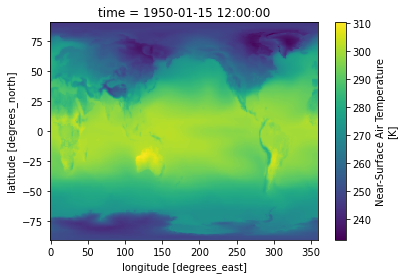

In [8]:
ds.tas.sel(time='1950-01').squeeze().plot()

## Global surface air temperature time series 

* We will also use an area weighting factor 
* First get a cube of grid-box areas

In [9]:
files_area = esgf_search(variable_id='areacella', activity_id='CMIP',
                         experiment_id='historical', institution_id="NCAR", source_id="CESM2")
ds_area = xr.open_dataset(files_area[0])
ds_area

https://esgf-node.llnl.gov/esg-search/search/?variable_id=areacella&activity_id=CMIP&experiment_id=historical&institution_id=NCAR&source_id=CESM2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?variable_id=areacella&activity_id=CMIP&experiment_id=historical&institution_id=NCAR&source_id=CESM2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?variable_id=areacella&activity_id=CMIP&experiment_id=historical&institution_id=NCAR&source_id=CESM2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
https://esgf-node.llnl.gov/esg-search/search/?variable_id=areacella&activity_id=CMIP&experiment_id=historical&institution_id=NCAR&source_id=CESM2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=30


/home/h06/ncreaser/.conda/envs/climate_ml_tutorial/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: nbnd
Data variables:
    lat_bnds   (lat, nbnd) float64 ...
    lon_bnds   (lon, nbnd) float64 ...
    areacella  (lat, lon) float32 ...
Attributes: (12/45)
    _NCProperties:          version=1|netcdflibversion=4.4.1.1|hdf5libversion...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  306600.0
    ...                     ...
    sub_experiment_id:      none
    table_id:               fx
    tracking_id:            hdl:21.14100/54fe4682-51a1-43ca-a7d5-66b7bca3f8c8
    variable_id:            areacella
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r10i1p1f1

* first line of code here sums over the latitude and longitude dimensions to get the total area 
* the second line multiply's each temperature point by its grid-box area, then divides by the total area 
    * this makes our time-series area-weighted 

In [10]:
total_area = ds_area.areacella.sum(dim=['lon', 'lat'])
ta_timeseries = (ds.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
ta_timeseries

<xarray.DataArray (time: 1980)>
dask.array<truediv, shape=(1980,), dtype=float32, chunksize=(600,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

* Load this data

In [14]:
%time ta_timeseries.load()

CPU times: user 3.54 s, sys: 2.18 s, total: 5.72 s
Wall time: 50.3 s


<xarray.DataArray (time: 1980)>
array([284.99948, 285.23215, 285.85364, ..., 288.54376, 287.61884,
       287.06284], dtype=float32)
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

* Finally plot our time-series 
* The second line of code plots a rolling mean of the time-series using `.rolling`


Text(0.5, 1.0, 'Global Mean Surface Air Temperature')

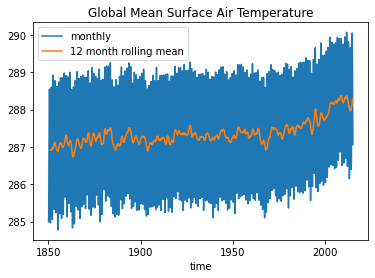

In [15]:
ta_timeseries.plot(label='monthly')
ta_timeseries.rolling(time=12).mean().plot(label='12 month rolling mean')
plt.legend()
plt.title('Global Mean Surface Air Temperature')

## Viewing metadata with Xarray

* We can view coordinates in Xarray using `.coords`
* Then use square brackets to access the coordinate, like a dictionary


In [22]:
ds.tas.coords

Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

In [21]:
ds.tas.coords['time']

<xarray.DataArray 'time' (time: 1980)>
array([cftime.DatetimeNoLeap(1850, 1, 15, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 2, 14, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 3, 15, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2014, 10, 15, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 11, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 12, 15, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    standard_name:  time
    title:          time
    type:           double
    _ChunkSizes:    512

* We can index the time coordinates, heres the first time-point

In [23]:
ds.tas.coords['time'][0]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(1850, 1, 15, 12, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 1850-01-15 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    standard_name:  time
    title:          time
    type:           double
    _ChunkSizes:    512

* `.atters` returns a dictionary of all extra metadata

In [24]:
ds.tas.attrs

{'cell_measures': 'area: areacella',
 'cell_methods': 'area: time: mean',
 'comment': 'near-surface (usually, 2 meter) air temperature',
 'description': 'near-surface (usually, 2 meter) air temperature',
 'frequency': 'mon',
 'id': 'tas',
 'long_name': 'Near-Surface Air Temperature',
 'mipTable': 'Amon',
 'out_name': 'tas',
 'prov': 'Amon ((isd.003))',
 'realm': 'atmos',
 'standard_name': 'air_temperature',
 'time': 'time',
 'time_label': 'time-mean',
 'time_title': 'Temporal mean',
 'title': 'Near-Surface Air Temperature',
 'type': 'real',
 'units': 'K',
 'variable_id': 'tas',
 '_ChunkSizes': array([  1, 192, 288], dtype=int32)}

In [25]:
ds.tas.attrs['standard_name']

'air_temperature'

* Do the same within the time coordinate

In [26]:
ds.tas.coords['time'].attrs

{'axis': 'T',
 'bounds': 'time_bnds',
 'standard_name': 'time',
 'title': 'time',
 'type': 'double',
 '_ChunkSizes': 512}